# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

---

In this notebook, we train a CNN on augmented images from the CIFAR-10 database.

### 1. Load CIFAR-10 Database

In [1]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


### 2. Visualize the First 24 Training Images

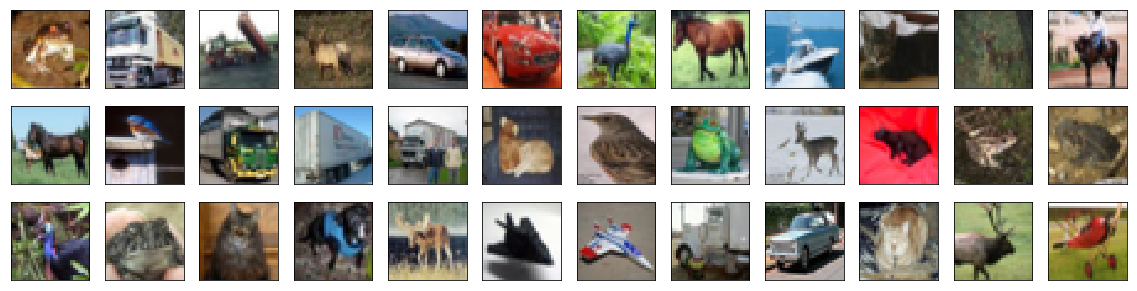

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [3]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [4]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

#up until this point, everything is the same

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Create and Configure Augmented Image Generator

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

### 6. Visualize Original and Augmented Images

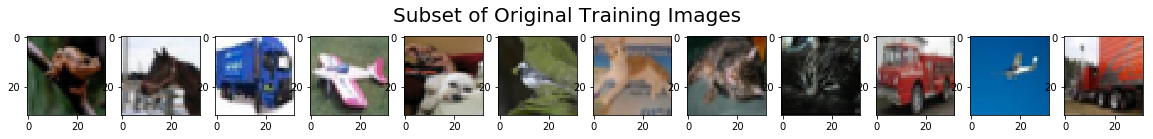

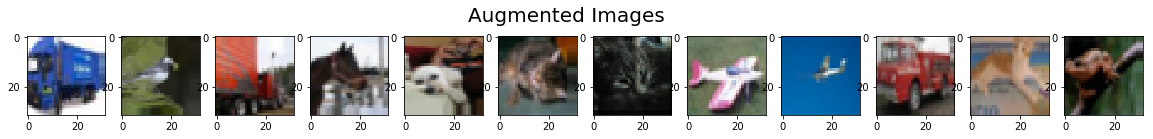

In [15]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
__________

### 8. Compile the Model 

In [17]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 9. Train the Model 

In [19]:
from keras.callbacks import ModelCheckpoint   
import time

batch_size = 32
epochs = 100

# train the model
t0 = time.time()
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, save_best_only=True)

model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, #not sure why this has to be # rows/batch_size
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size) #for validation, we do the same thing
print('training takes: ', time.time() - t0)
#no augmentation:
#CNN: 2927.65 seconds, 29.3 seconds per epoch, Test accuracy: 0.6852
#MLP: 1236.17 seconds, 61.8 seconds per epoch
#with augmentation:
#CNN: 3008.60 seconds, 30 seconds per epoch, Test accuracy: 0.6621

Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.02800, saving model to aug_model.weights.best.hdf5
31s - loss: 1.1491 - acc: 0.6073 - val_loss: 1.0280 - val_acc: 0.6637
Epoch 2/100
Epoch 00001: val_loss did not improve
31s - loss: 1.1654 - acc: 0.6073 - val_loss: 1.0286 - val_acc: 0.6659
Epoch 3/100
Epoch 00002: val_loss did not improve
31s - loss: 1.1793 - acc: 0.6032 - val_loss: 1.0749 - val_acc: 0.6471
Epoch 4/100
Epoch 00003: val_loss did not improve
30s - loss: 1.2014 - acc: 0.5956 - val_loss: 1.0317 - val_acc: 0.6558
Epoch 5/100
Epoch 00004: val_loss did not improve
30s - loss: 1.2214 - acc: 0.5914 - val_loss: 1.1366 - val_acc: 0.6163
Epoch 6/100
Epoch 00005: val_loss did not improve
30s - loss: 1.2390 - acc: 0.5837 - val_loss: 1.0965 - val_acc: 0.6290
Epoch 7/100
Epoch 00006: val_loss did not improve
30s - loss: 1.2627 - acc: 0.5754 - val_loss: 1.1764 - val_acc: 0.6099
Epoch 8/100
Epoch 00007: val_loss did not improve
30s - loss: 1.2834 - acc: 0.5674 - val_loss: 1.1716 

Epoch 00068: val_loss did not improve
30s - loss: 1.8304 - acc: 0.3331 - val_loss: 1.7139 - val_acc: 0.3490
Epoch 70/100
Epoch 00069: val_loss did not improve
29s - loss: 1.8430 - acc: 0.3349 - val_loss: 1.8398 - val_acc: 0.3078
Epoch 71/100
Epoch 00070: val_loss did not improve
30s - loss: 1.8517 - acc: 0.3273 - val_loss: 1.8341 - val_acc: 0.3508
Epoch 72/100
Epoch 00071: val_loss did not improve
30s - loss: 1.8618 - acc: 0.3243 - val_loss: 1.7630 - val_acc: 0.3657
Epoch 73/100
Epoch 00072: val_loss did not improve
30s - loss: 1.8608 - acc: 0.3241 - val_loss: 1.7093 - val_acc: 0.3794
Epoch 74/100
Epoch 00073: val_loss did not improve
30s - loss: 1.8617 - acc: 0.3223 - val_loss: 1.8585 - val_acc: 0.3146
Epoch 75/100
Epoch 00074: val_loss did not improve
29s - loss: 1.8679 - acc: 0.3213 - val_loss: 1.7893 - val_acc: 0.3072
Epoch 76/100
Epoch 00075: val_loss did not improve
29s - loss: 1.8644 - acc: 0.3176 - val_loss: 1.7807 - val_acc: 0.3315
Epoch 77/100
Epoch 00076: val_loss did not im

### 10. Load the Model with the Best Validation Accuracy

In [20]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

In [21]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.6621


In [22]:
# new model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary() # total params is 1.2M, compared to default CNN of 528k, and MLP of 3M

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [23]:
batch_size = 32
epochs = 100

t0 = time.time()
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, #not sure why this has to be # rows/batch_size
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size) #for validation, we do the same thing

print('CNN training takes: ', time.time() - t0)
#Customized+augmented CNN: 16021.610558986664, 1602 seconds per epoch
#Customized CNN: 16554.56 seconds, 165.5 seconds per epoch
#default CNN: 2927.65 seconds, 29.3 seconds per epoch
#MLP: 1236.17 seconds, 61.8 seconds per epoch

Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.64545, saving model to model.weights.best.hdf5
162s - loss: 1.8816 - acc: 0.3116 - val_loss: 1.6454 - val_acc: 0.4014
Epoch 2/100
Epoch 00001: val_loss improved from 1.64545 to 1.45902, saving model to model.weights.best.hdf5
162s - loss: 1.6005 - acc: 0.4107 - val_loss: 1.4590 - val_acc: 0.4793
Epoch 3/100
Epoch 00002: val_loss improved from 1.45902 to 1.40981, saving model to model.weights.best.hdf5
162s - loss: 1.4721 - acc: 0.4651 - val_loss: 1.4098 - val_acc: 0.4932
Epoch 4/100
Epoch 00003: val_loss improved from 1.40981 to 1.30765, saving model to model.weights.best.hdf5
160s - loss: 1.3927 - acc: 0.4984 - val_loss: 1.3076 - val_acc: 0.5374
Epoch 5/100
Epoch 00004: val_loss improved from 1.30765 to 1.20458, saving model to model.weights.best.hdf5
161s - loss: 1.3192 - acc: 0.5272 - val_loss: 1.2046 - val_acc: 0.5713
Epoch 6/100
Epoch 00005: val_loss improved from 1.20458 to 1.19620, saving model to model.weights.best.hdf5
1

Epoch 00056: val_loss did not improve
162s - loss: 0.7804 - acc: 0.7358 - val_loss: 0.6981 - val_acc: 0.7633
Epoch 58/100
Epoch 00057: val_loss did not improve
162s - loss: 0.7761 - acc: 0.7384 - val_loss: 0.7650 - val_acc: 0.7361
Epoch 59/100
Epoch 00058: val_loss did not improve
161s - loss: 0.7721 - acc: 0.7371 - val_loss: 0.7321 - val_acc: 0.7625
Epoch 60/100
Epoch 00059: val_loss did not improve
160s - loss: 0.7712 - acc: 0.7389 - val_loss: 0.7515 - val_acc: 0.7448
Epoch 61/100
Epoch 00060: val_loss did not improve
159s - loss: 0.7791 - acc: 0.7352 - val_loss: 0.7514 - val_acc: 0.7645
Epoch 62/100
Epoch 00061: val_loss did not improve
158s - loss: 0.7718 - acc: 0.7413 - val_loss: 0.6974 - val_acc: 0.7669
Epoch 63/100
Epoch 00062: val_loss did not improve
160s - loss: 0.7761 - acc: 0.7382 - val_loss: 0.7429 - val_acc: 0.7552
Epoch 64/100
Epoch 00063: val_loss did not improve
159s - loss: 0.7773 - acc: 0.7386 - val_loss: 0.6983 - val_acc: 0.7675
Epoch 65/100
Epoch 00064: val_loss di

In [24]:
model.load_weights('model.weights.best.hdf5')

score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])
#CNN customized+augmented effort: Test accuracy: 0.7965
#CNN customized effort: Test accuracy: 0.7869
#CNN default effort: Test accuracy: 0.6852
#note that the best score achieved is 95%


 Test accuracy: 0.7965


In [27]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
optimizers = [opt, 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for optimizer in optimizers:
    print(optimizer)
    t0 = time.time()
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.summary() # total params is 65k, even less than default CNN of 528k, compared to 3M in MLP

    model.compile(loss='categorical_crossentropy', optimizer = optimizer,  metrics = ['accuracy'])
    checkpointer = ModelCheckpoint(filepath = 'model.weights.best.hdf5', verbose = 1, save_best_only=True)

    model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, #not sure why this has to be # rows/batch_size
                    epochs=10, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size) #for validation, we do the same thing
    
    model.load_weights('model.weights.best.hdf5')

    score = model.evaluate(x_test, y_test, verbose = 0)
    print('CNN training takes: ', time.time() - t0, ' for optimizer ', optimizer)
    print('Test accuracy:', score[1], ' for optimizer ', optimizer)
    print('\n')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
__________

_________________________________________________________________
dropout_19 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1180160   
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5130      
Total params: 1,250,858
Trainable params: 1,250,858
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
Epoch 00000: val_loss improved from inf to 1.35064, saving model to model.weights.best.hdf5
170s - loss: 1.6507 - acc: 0.3983 - val_loss: 1.3506 - val_acc: 0.5116
Epoch 2/10
Epoch 00001: 

Epoch 00000: val_loss improved from inf to 1.41535, saving model to model.weights.best.hdf5
183s - loss: 1.7403 - acc: 0.3593 - val_loss: 1.4154 - val_acc: 0.4800
Epoch 2/10
Epoch 00001: val_loss improved from 1.41535 to 1.17980, saving model to model.weights.best.hdf5
180s - loss: 1.3753 - acc: 0.5048 - val_loss: 1.1798 - val_acc: 0.5882
Epoch 3/10
Epoch 00002: val_loss improved from 1.17980 to 1.06985, saving model to model.weights.best.hdf5
182s - loss: 1.2140 - acc: 0.5703 - val_loss: 1.0698 - val_acc: 0.6234
Epoch 4/10
Epoch 00003: val_loss improved from 1.06985 to 1.00607, saving model to model.weights.best.hdf5
179s - loss: 1.1212 - acc: 0.6008 - val_loss: 1.0061 - val_acc: 0.6506
Epoch 5/10
Epoch 00004: val_loss improved from 1.00607 to 0.91145, saving model to model.weights.best.hdf5
180s - loss: 1.0464 - acc: 0.6299 - val_loss: 0.9114 - val_acc: 0.6723
Epoch 6/10
Epoch 00005: val_loss improved from 0.91145 to 0.86703, saving model to model.weights.best.hdf5
180s - loss: 0.990

Epoch 00004: val_loss improved from 0.88724 to 0.88717, saving model to model.weights.best.hdf5
174s - loss: 0.9723 - acc: 0.6568 - val_loss: 0.8872 - val_acc: 0.6834
Epoch 6/10
Epoch 00005: val_loss improved from 0.88717 to 0.79061, saving model to model.weights.best.hdf5
175s - loss: 0.9066 - acc: 0.6823 - val_loss: 0.7906 - val_acc: 0.7260
Epoch 7/10
Epoch 00006: val_loss improved from 0.79061 to 0.73589, saving model to model.weights.best.hdf5
174s - loss: 0.8674 - acc: 0.6964 - val_loss: 0.7359 - val_acc: 0.7448
Epoch 8/10
Epoch 00007: val_loss did not improve
173s - loss: 0.8330 - acc: 0.7075 - val_loss: 0.7647 - val_acc: 0.7333
Epoch 9/10
Epoch 00008: val_loss did not improve
171s - loss: 0.8028 - acc: 0.7206 - val_loss: 0.7510 - val_acc: 0.7391
Epoch 10/10
Epoch 00009: val_loss improved from 0.73589 to 0.65433, saving model to model.weights.best.hdf5
172s - loss: 0.7774 - acc: 0.7273 - val_loss: 0.6543 - val_acc: 0.7774
CNN training takes:  1753.826706647873  for optimizer  ada

miniproject link: https://classroom.udacity.com/nanodegrees/nd889/parts/16cf5df5-73f0-4afa-93a9-de5974257236/modules/53b2a19e-4e29-4ae7-aaf2-33d195dbdeba/lessons/37492b45-ee34-4dc3-a2e8-076149f92562/concepts/16a83ecf-dd95-4bbe-8760-57ccc8f26df7

input answers:
- achieved Test accuracy: 0.7965
- used optimizer opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
- for different optimizers (time it takes to do 10 epochs, training set accuracy):
    - custom rmsprop: 1719.39s, 0.6712
    - sgd: 1650.29s, 0.612
    - rmsprop: 1720.27s, 0.6869
    - adagrad: 1688.45s, 0.7255
    - adadelta: 1812.39s, 0.7467
    - adam: 1793.98s, 0.7574
    - adamax: 1753.82s, 0.7806
    - nadam: 1779.19s, 0.6834